In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import platform
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sklearn 
import cv2
import json
from glob import glob

In [2]:
device = torch.device('cuda')

In [3]:
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

- os: Windows-10-10.0.19041-SP0
- python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.3.5
- numpy: 1.19.1
- sklearn: 1.0.2
- pytorch: 1.10.1+cpu
- opencv: 4.5.5


In [4]:
def accuracy_function(real, pred):    
    score = f1_score(real, pred, average='macro')
    return score

def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

# 데이터 파악

In [5]:
train_csv = sorted(glob('./_data/train/*/*.csv'))
train_jpg = sorted(glob('./_data/train/*/*.jpg'))
train_json = sorted(glob('./_data/train/*/*.json'))

test_csv = sorted(glob('./_data/test/*/*.csv'))
test_jpg = sorted(glob('./_data/test/*/*.jpg'))
test_json = sorted(glob('./_data/test/*/*.json'))

In [6]:
print(f'train_csv: {len(train_csv)}')
print(f'train_jpg: {len(train_jpg)}')
print(f'train_json: {len(train_json)}')

print(f'test_csv: {len(test_csv)}')
print(f'test_jpg: {len(test_jpg)}')
print(f'test_json: {len(test_json)}')

train_csv: 5767
train_jpg: 5767
train_json: 5767
test_csv: 51906
test_jpg: 51906
test_json: 0


## train 데이터 5767개, test 데이터 51906개
### test 데이터 수에비해 train 데이터가 매우 적고 json데이터는 존재하지 않음

In [7]:
crop_dict = {1:'딸기', 
             2:'토마토',
             3:'파프리카',
             4:'오이', 
             5:'고추',
             6: '시설포도'}

area_dict = {1:'열매',
             2:'꽃',
             3:'잎',
             4:'가지',
             5:'줄기',
             6:'뿌리',
             7:'해충'}

task_dict = {0:'정상',
             1:'병해',
             2:'생리장애',
             3:'보호제처리반응'}

disease_dict = {'00' : '정상',
                
                # 병해 a
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                
                # 생리장애 b
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                
                # 보호제 처리반응 c
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

            # 시설 과채류
grow_dict = {11:'유묘기',
             12:'생장기',
             13:'착화/과실기',
             
             # 시설 과수류 (포도)
             21:'발아기',
             22:'개화기',
             23:'신초생장기',
             24:'과실성숙기',
             25:'수확기',
             26:'휴면기'}

risk_dict = {0:'정상',
             1:'초기',
             2:'중기',
             3:'말기'}

In [41]:
def img_load(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (384, 512))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:32<00:00, 176.66it/s]


In [9]:
crops = []
areas = []
tasks = []
diseases = []
risks = []
grows = []
labels = []
dates = []
times = []
parts=[]
roi = []
for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        
        crop = sample['annotations']['crop']
        area = sample['annotations']['area']
        task = sample['description']['task']
        grow = sample['annotations']['grow']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        date = sample['description']['date']
        time = sample['description']['time']
        label=f"{crop}_{disease}_{risk}"        
        
        crops.append(crop)
        areas.append(area)
        tasks.append(task)
        grows.append(grow)
        diseases.append(disease)
        risks.append(risk)
        dates.append(date)
        times.append(time)
        labels.append(label)
        
        
        r = sample['annotations']['bbox'][0]
        temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
        roi.append(temp)    
        
        p = []
        
        for part in sample['annotations']['part']:
            p.append({
                'bbox': [
                    int(part['x']), int(part['y']), int(part['w']), int(part['h'])
                ],
                'id': part['id']
            })
        parts.append(p)

# 데이터 확인
## 데이터 변수 설명 파일을 통해 확인한 것
* 시설과채류 : 딸기, 토마토, 파프리카, 오이, 고추
* 시설과수류 : 포도

### a. 병해
* 시설과채류는 모두 흰가루 병에 걸릴 수 있음
* 시설과채류 중 딸기와 토마토는 잿빛곰팡이, 파프리카는 잘록, 오이는 노균, 고추는 탄저병에 걸릴 수 있음
* 시설과수류인 포도는 노균과 탄저병에 걸릴 수 있음

### b. 생리장애
* 시설과채류는 다량원소결핍 N,P,K에 걸릴 수 있음
* 냉해피해는 딸기와 오이
* 칼슘결핍은 토마토 파프리카
* 열과는 토마토
* 포도는 일소피해, 축과병

### c. 보호제처리반응 
* 각 작물마다 걸릴 수 있는 병해에 대한 보호제 처리반응

In [48]:
# 병해부위 갯수
parts_i = [len(x) for x in parts]

In [11]:
data = pd.DataFrame({'crops':crops,'areas':areas,'tasks':tasks,'diseases':diseases,'risks':risks, 'grows':grows, 'labels':labels, 'dates':dates, 'times':times, 'parts':parts_i})
data

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts
0,3,3,2,b7,1,13,3_b7_1,20211126,0935,2
1,3,5,0,00,0,11,3_00_0,20210914,0925,0
2,3,1,0,00,0,13,3_00_0,20210624,1332,0
3,3,3,0,00,0,11,3_00_0,20210915,1616,0
4,3,1,0,00,0,13,3_00_0,20210624,1430,0
...,...,...,...,...,...,...,...,...,...,...
5762,3,5,0,00,0,11,3_00_0,20210930,1234,0
5763,1,3,0,00,0,11,1_00_0,20210916,0952,0
5764,2,3,1,a5,2,12,2_a5_2,20211017,1249,1
5765,1,3,0,00,0,12,1_00_0,20211007,0956,0


# 작물 분포 확인

In [12]:
data_txt = data.copy()
data_txt.crops = data_txt.crops.apply(lambda x: crop_dict[x]+'('+ str(x) +')')
data_txt.areas = data_txt.areas.apply(lambda x: area_dict[x]+'('+ str(x) +')')
data_txt.tasks = data_txt.tasks.apply(lambda x: task_dict[x]+'('+ str(x) +')')
data_txt.diseases = data_txt.diseases.apply(lambda x: disease_dict[x]+'('+ str(x) +')')
data_txt.risks = data_txt.risks.apply(lambda x: risk_dict[x]+'('+ str(x) +')')
data_txt.grows = data_txt.grows.apply(lambda x: grow_dict[x]+'('+ str(x) +')')
data_txt.labels = data_txt.labels.apply(lambda x: crop_dict[int(x.split('_')[0])] + '_' + disease_dict[x.split('_')[1]] + '_' + risk_dict[int(x.split('_')[2])])
data_txt

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts
0,파프리카(3),잎(3),생리장애(2),다량원소결핍 (P)(b7),초기(1),착화/과실기(13),파프리카_다량원소결핍 (P)_초기,20211126,0935,2
1,파프리카(3),줄기(5),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210914,0925,0
2,파프리카(3),열매(1),정상(0),정상(00),정상(0),착화/과실기(13),파프리카_정상_정상,20210624,1332,0
3,파프리카(3),잎(3),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210915,1616,0
4,파프리카(3),열매(1),정상(0),정상(00),정상(0),착화/과실기(13),파프리카_정상_정상,20210624,1430,0
...,...,...,...,...,...,...,...,...,...,...
5762,파프리카(3),줄기(5),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210930,1234,0
5763,딸기(1),잎(3),정상(0),정상(00),정상(0),유묘기(11),딸기_정상_정상,20210916,0952,0
5764,토마토(2),잎(3),병해(1),토마토흰가루병(a5),중기(2),생장기(12),토마토_토마토흰가루병_중기,20211017,1249,1
5765,딸기(1),잎(3),정상(0),정상(00),정상(0),생장기(12),딸기_정상_정상,20211007,0956,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5767 entries, 0 to 5766
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   crops     5767 non-null   int64 
 1   areas     5767 non-null   int64 
 2   tasks     5767 non-null   int64 
 3   diseases  5767 non-null   object
 4   risks     5767 non-null   int64 
 5   grows     5767 non-null   int64 
 6   labels    5767 non-null   object
 7   dates     5767 non-null   object
 8   times     5767 non-null   object
 9   parts     5767 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 450.7+ KB


In [14]:
import matplotlib
from matplotlib import font_manager, rc

font_path ="C:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)

# 촬영부위와 병해유무
## 열매와 잎에 발생한 병해 데이터만 있음

In [15]:
pd.crosstab(data_txt.tasks,data_txt.areas, margins=True).style.background_gradient()

areas,가지(4),꽃(2),열매(1),잎(3),줄기(5),All
tasks,,,,,,
병해(1),0,0,151,538,0,689
생리장애(2),0,0,21,1113,0,1134
정상(0),4,156,327,3090,367,3944
All,4,156,499,4741,367,5767


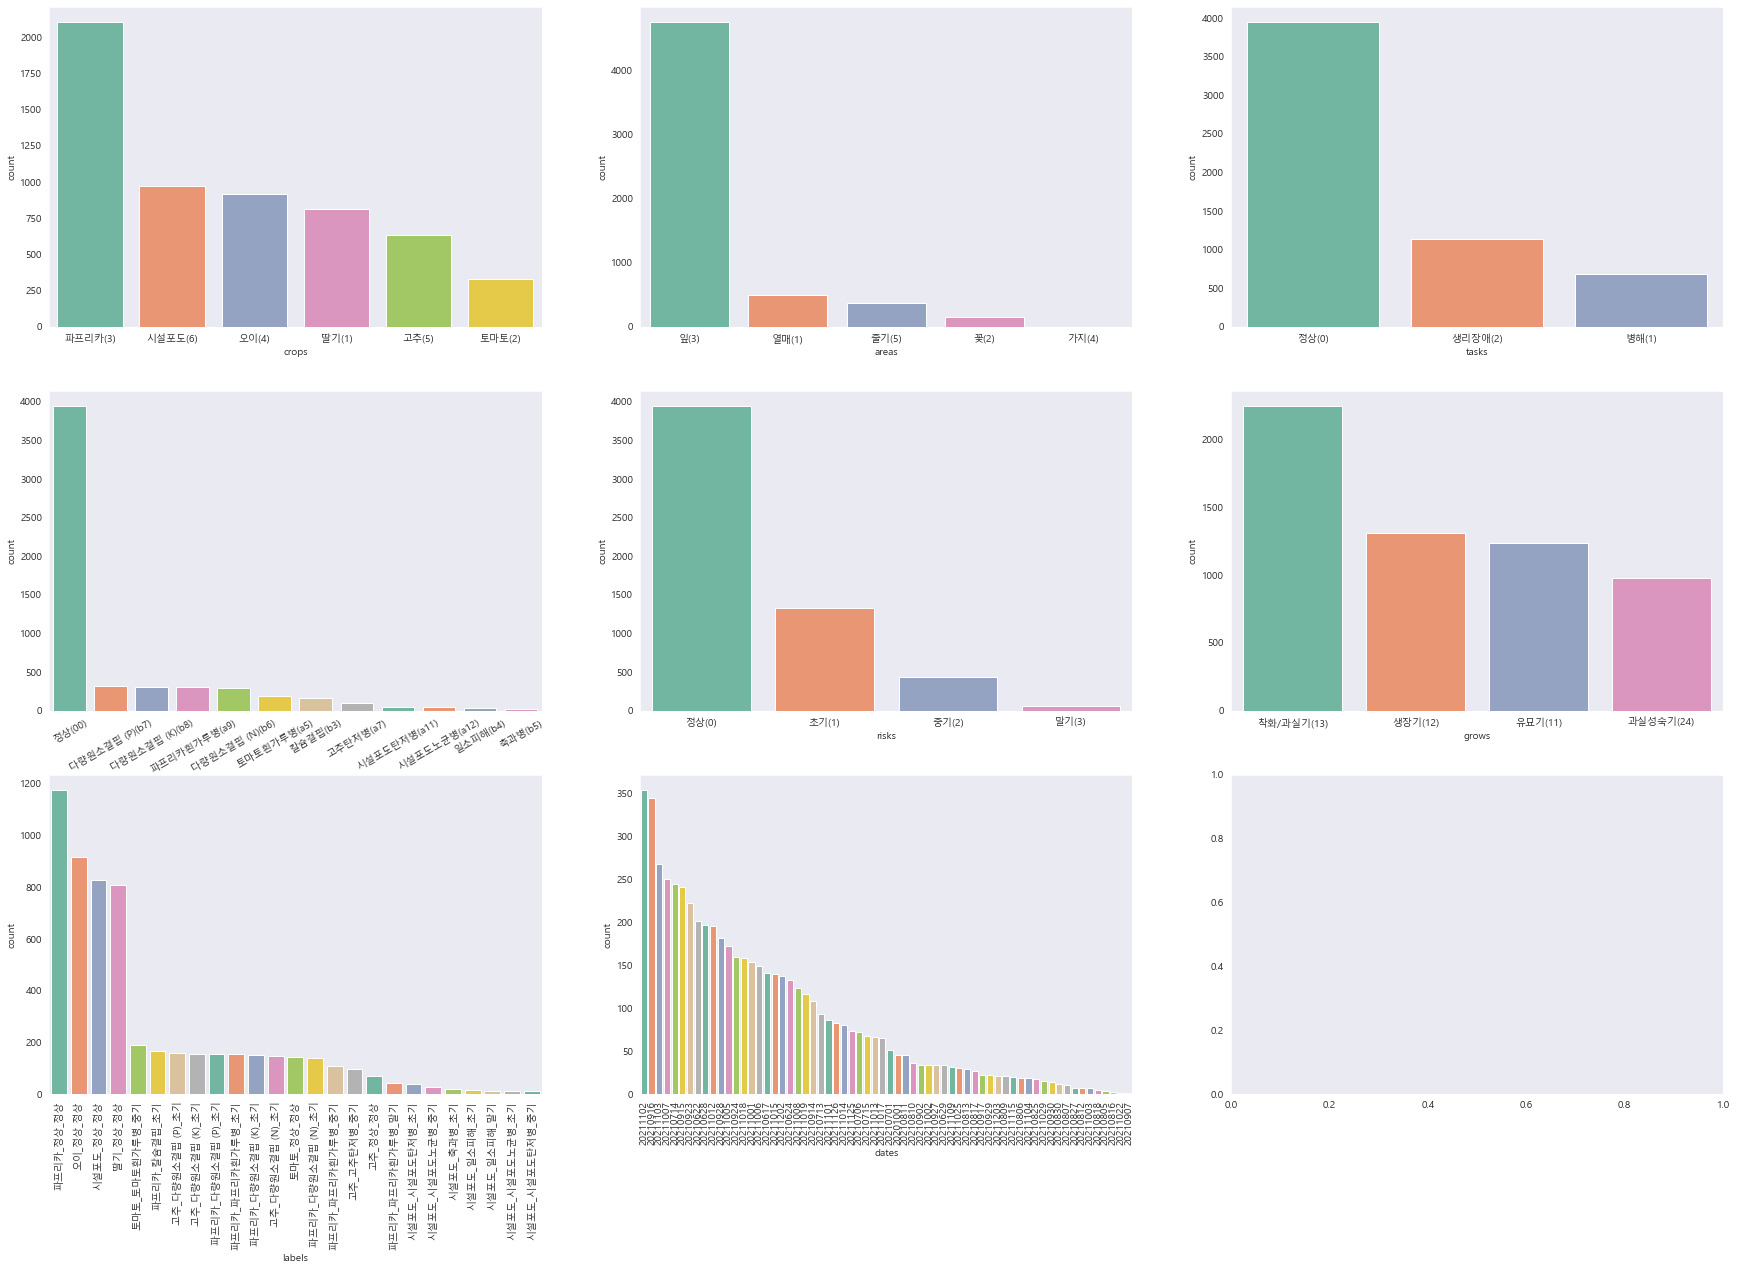

In [16]:
f, ax = plt.subplots(3,3, figsize=(30,20))
for i, col in enumerate(data_txt.columns.tolist()[:-2]):
    sns.countplot(x=data_txt[col], ax=ax[i//3][i%3], palette='Set2', order = data_txt[col].value_counts().index)
# diseases만 회전
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30)
ax[2,0].set_xticklabels(ax[2,0].get_xticklabels(), rotation=90)
ax[2,1].set_xticklabels(ax[2,1].get_xticklabels(), rotation=90)
plt.show()

# 데이터 불균형이 심함.
## 촬영 부위는 대부분 잎이고 질병이나 생리장애 데이터보다 정상 데이터가 훨씬 많음.
### 말기데이터 또한 부족

In [17]:
print(f'훈련 데이터 고유 라벨 수: {len(data.labels.unique())}')

훈련 데이터 고유 라벨 수: 25


In [18]:
pd.crosstab(data_txt.labels,data_txt.crops, margins=True).style.background_gradient()

crops,고추(5),딸기(1),시설포도(6),오이(4),토마토(2),파프리카(3),All
labels,,,,,,,
고추_고추탄저병_중기,99,0,0,0,0,0,99
고추_다량원소결핍 (K)_초기,157,0,0,0,0,0,157
고추_다량원소결핍 (N)_초기,148,0,0,0,0,0,148
고추_다량원소결핍 (P)_초기,159,0,0,0,0,0,159
고추_정상_정상,69,0,0,0,0,0,69
딸기_정상_정상,0,810,0,0,0,0,810
시설포도_시설포도노균병_중기,0,0,29,0,0,0,29
시설포도_시설포도노균병_초기,0,0,13,0,0,0,13
시설포도_시설포도탄저병_중기,0,0,12,0,0,0,12


# 부족한 데이터
## 딸기, 오이: 정상 이외 모두
## 토마토는 정상,흰가루 이외 모두
## 파프리카 잘록
## 고추 흰가루
### 보호제처리반응에 대한 라벨 없음
#### git에 렌더링이 안돼서 part나누어 업로드 